# 집값 예측 경진대회

## 패키지 import 및 데이터 전처리

In [257]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [258]:
df = pd.read_csv('C:/Users/Jaesu/github_desktop/Dacon-Basic/집값-예측/Data/train.csv')
test = pd.read_csv('C:/Users/Jaesu/github_desktop/Dacon-Basic/집값-예측/Data/test.csv')

In [259]:
df.head()

,id,Overall Qual,Gr Liv Area,Exter Qual,Garage Cars,Garage Area,Kitchen Qual,Total Bsmt SF,1st Flr SF,Bsmt Qual,Full Bath,Year Built,Year Remod/Add,Garage Yr Blt,target
0,1,10,2392,Ex,3,968,Ex,2392,2392,Ex,2,2003,2003,2003,386250
1,2,7,1352,Gd,2,466,Gd,1352,1352,Ex,2,2006,2007,2006,194000
2,3,5,900,TA,1,288,TA,864,900,TA,1,1967,1967,1967,123000
3,4,5,1174,TA,2,576,Gd,680,680,TA,1,1900,2006,2000,135000
4,5,7,1958,Gd,3,936,Gd,1026,1026,Gd,2,2005,2005,2005,250000


`-` id는 필요없으니 제거

In [260]:
df.drop('id', axis = 1, inplace = True)
test.drop('id', axis = 1, inplace = True)

`-` 결측치는 없다

`-` 분석의 편의를 위해 컬럼명을 바꾸겠다

In [261]:
## 공백과 슬래쉬를 _로 대체 1을 숫자가 아닌 다른 문자로 바꿈 

df.rename(columns = dict(zip(df.columns, [column.replace(' ', '_').replace('/', '_').replace('1', 'fir') for column in df.columns])), inplace = True) 
test.rename(columns = dict(zip(test.columns, [column.replace(' ', '_').replace('/', '_').replace('1', 'fir') for column in test.columns])), inplace = True) 

`-` 범주형 변수는 Exter Qual(외관 재료 품질;4개), Kitchen Qual(부엌 품질; 4개), Bsmt Qual(지하실 높이;5개)이다

`-` 총 5개의 등급이 존재하는데 Poor 등급은 Bsmt Qual에 1개 존재한다(나머지는 0개)

`-` 아예 poor등급이 존재하지 않는걸 수 도 있고 poor등급이 존재하는데 poor등급에 해당하는 건물이 존재하지 않는걸 수 도 있다

`-` 편의상 후자라고 생각하자

`-` 이들은 순서형 변수이므로 라벨 인코딩을 해주자

`-` 좋은 등급이 큰 값을 가지도록 하기위해 라벨인코딩을 정의해주자

In [262]:
def label_encoding(data):
    grade_label = ['Po', 'Fa', 'TA', 'Gd', 'Ex'] ## 0~4점
    
    for grade, label in enumerate(grade_label):
        if data == label:
            return grade

In [263]:
for col in df.columns[df.dtypes == 'object']:
    df[col] = df[col].apply(lambda x: label_encoding(x))

In [264]:
df.head()

,Overall_Qual,Gr_Liv_Area,Exter_Qual,Garage_Cars,Garage_Area,Kitchen_Qual,Total_Bsmt_SF,first_Flr_SF,Bsmt_Qual,Full_Bath,Year_Built,Year_Remod_Add,Garage_Yr_Blt,target
0,10,2392,4,3,968,4,2392,2392,4,2,2003,2003,2003,386250
1,7,1352,3,2,466,3,1352,1352,4,2,2006,2007,2006,194000
2,5,900,2,1,288,2,864,900,2,1,1967,1967,1967,123000
3,5,1174,2,2,576,3,680,680,2,1,1900,2006,2000,135000
4,7,1958,3,3,936,3,1026,1026,3,2,2005,2005,2005,250000


`-` 라벨 인코딩이 잘 되었다

### 로그 변환 및 이상점 제거

`-` 앞서 EDA에서 집값(target)이 오른쪽으로 꼬리가 긴 분포임을 확인했다

`-` 정규분포로 맞춰주기 위해 로그변환을 하자

In [265]:
import scipy.stats as stats

In [268]:
sns.set_theme()

<AxesSubplot:>

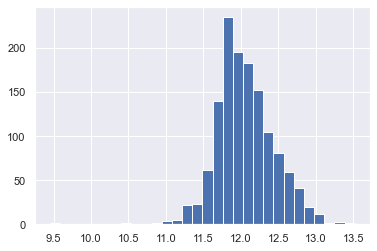

In [269]:
np.log(df['target']).hist(bins = 30)

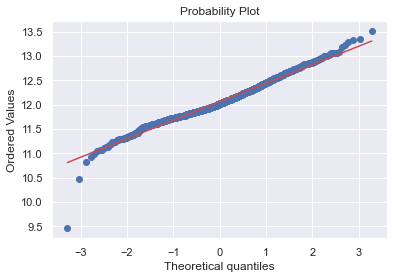

In [267]:
_ = stats.probplot(np.log(df['target']), plot = plt)

`-` 로그 변환을 했지만 정규분포를 따르지 않는것처럼 보인다

`-` 샤피로-윌크 검정을 통해 정확히 확인하자

In [270]:
test_stat, p_val = stats.shapiro(np.log(df['target']))

In [271]:
p_val, np.log(df['target']).skew() ## p값과 왜도

(4.748497602069524e-13, 0.08070163740417918)

`-` 안타깝게도 정규분포를 따르지 않는다

`-` 왜도는 $0.08$로 거의 $0$

`-` 그런데 Q-Q플랏을 보면 심각한 이상치가 보인다(-3부근에 2개)

`-` 저런 이상치를 예측하는 것은 불가능해보이니 제거하자

`-` 값이 큰쪽으로도 이상점이 있는데 제거할지 말지 고민중이다

`-` 가장 비싼 집이 745000 달러인데 Gr_Liv_Area(지상층 생활 면적)이 4476으로 매우 넓다!

`-` 근데 생각해보니 제거하는 것이 맞는 것 같다(심각한 이상치로 인해 큰 영향을 끼칠 수 있음)

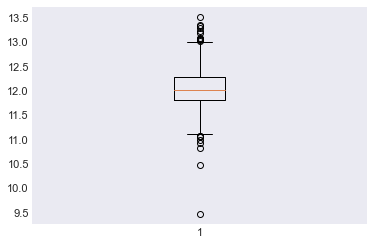

In [272]:
with plt.style.context('seaborn-dark'): 
    plt.boxplot(np.log(df['target']))
plt.show()

`-` 로그 변환을 해서 나온 이상치들을 제거하자

In [19]:
def remove_outlier(df):
    Q1 = np.log(df).quantile(0.25)
    Q3 = np.log(df).quantile(0.75)
    IQR = Q3 - Q1   

    filter_ = (np.log(df) >= Q1 - 1.5*IQR) & (np.log(df) <= Q3 + 1.5*IQR)
    return filter_

`-` df의 이상점을 제거한 df2를 만듦

In [279]:
df2 = df.copy()

`-` 위에서 제거한 이상점은 target의 이상점이다

`-` 그런데 위와 같이 이상점을 제거하면 target 전체를 기준으로 매우 큰 값 또는 작은 값만 제거된다

`-` 하지만 Overall Qual과 같은 변수로 target을 나눠서 보면 target 전체로 봤을 때의 이상점과 다르다

`-` 그렇기에 Overall Qual에 따른 target의 이상점을 제거하겠다

`-` 예컨대 Overall Qual이 3일 때 이상점으로 30만 달러의 집이 있다고 해도

`-` target 전체로 봤을 땐 이상점이 아니다

`-` 각각의 Overall_Qual에 대한 target의 이상점을 제거하자

`-` 기준을 Overall_Qual로 할지 Kitchen_Qual로 할지 고민이다

`-` 일단은 kitchen_Qual로 해보자

`-` 그리고 전체 target에 대한 이상점도 제거하자

`-` 위의 처럼 할려고 했는데 그냥 전체 target에 대한 이상점만 제거하기로 했다

`-` 이상점이 많다는건 test에서도 그럴 수 있다는 것인데 모두 제거하면 이를 예측하기 어렵다

`-` 이상점이 조금 있으면 없애도 큰 문제 없지만 많이 있다는 건 test에서도 그럴 수 있다는 것이고 이를 예측하려면 무작정 이상점 없애면 안된다

`-` 결론 : Overall_Qual에 따른 target의 이상점만 제거

In [280]:
# l = []
# for i in df2['Overall_Qual'].unique():
#     l.extend(remove_outlier(df2.query('Overall_Qual == @i')[['target']]).query('target == True').index.tolist()) ## 이상점이 아닌 인덱스번호만 추가
             
# l = list(set(l))

In [275]:
# l = []
# for i in df2['Kitchen_Qual'].unique():
#     l.extend(remove_outlier(df2.query('Kitchen_Qual == @i')[['target']]).query('target == True').index.tolist()) ## 이상점이 아닌 인덱스번호만 추가

# # l = list(set(l))
# l = list(set(l) & set(remove_outlier(df2[['target']]).query('target == True').index.tolist()))

In [276]:
# df2 = df2.loc[l,:].reset_index().drop('index', axis = 1)

`-` 이상점 제거 방식을 바꿈

In [281]:
df2 = df2[remove_outlier(np.log(df2['target']))]

<AxesSubplot:>

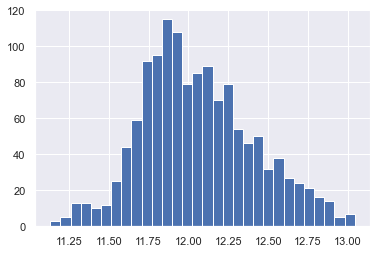

In [282]:
np.log(df2['target']).hist(bins = 30) ## 현재 방식

<AxesSubplot:>

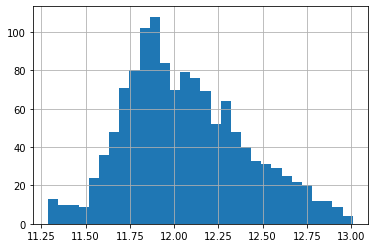

In [21]:
np.log(df2['target']).hist(bins = 30) ## 과거 방식

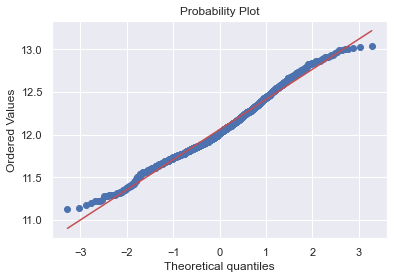

In [283]:
_ = stats.probplot(np.log(df2['target']), plot = plt) ## 현재 방식

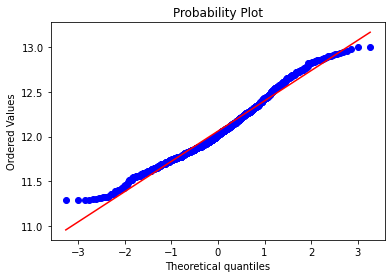

In [22]:
_ = stats.probplot(np.log(df2['target']), plot = plt) ## 과거 방식

In [284]:
test_stat, p_val = stats.shapiro(np.log(df2['target']))

In [33]:
p_val, np.log(df2['target']).skew() ## p값과 왜도; 현재 방식

(1.1874696781433158e-09, 0.3258074548404892)

In [24]:
p_val, np.log(df2['target']).skew() ## p값과 왜도; 과거 방식

(1.1122151810649683e-11, 0.4089823524750673)

`-` 이상으로 이상점 제거를 끝냈다

`-` 바꾼 이상점 제거 방식과 바꾸기 전에 이상점 제거 방식을 비교하니

`-` 오히려 바꾼 방식이 더 낫다

In [288]:
dt = df2.copy()

In [289]:
target = dt['target']  ## target
dt = dt.iloc[:, :-1]   ## target 제외한 데이터프레임

In [290]:
dt['After_1980Year_Built'] = dt['Year_Built'].apply(lambda x: 1 if x >= 1980 else 0) ## 1980년 이후는 1 이전은 0으로 코딩했다
## 데이콘에서 제공한 EDA코드에서 산점도를 보면 1980년을 기준으로 집값의 분포가 달라보임

In [291]:
dt.drop(['Year_Built', 'Year_Remod_Add', 'Garage_Yr_Blt'], axis = 1, inplace = True)

`-` train 셋에 포함된 피쳐외의 특징을 연도 피쳐가 가지고 있을 수 있으니 연도 변수로 위의 파생 변수를 사용하자

`-` 근데 연도를 연속형 변수 취급해서 사용하는 것이 맞나 싶다

`-` 연도 자체를 가지고 집값을 맞추기 보단 최근, 과거 같이 구간을 나눠서 집값을 예측하는 것이 더 나은 것 같다

`-` 1980년을 기준으로 이후와 이전을 나누어 범주형 변수로 코딩하자

`-` 모델링을 해보니 거의 유용하지 않은 정보였다

<AxesSubplot:xlabel='Garage_Area', ylabel='Count'>

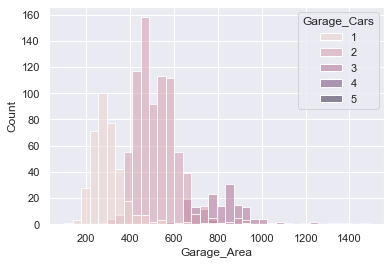

In [292]:
sns.histplot(data = dt, x = 'Garage_Area', hue= 'Garage_Cars')

`-` 차고의 면적과 차고에 들어가는 차량의 개수는 강한 상관관계를 보인다

`-` 차고 면적은 차고 자리 개수와 관련이 있다

`-` 차고 자리 개수에 따라 차고 면적의 분포가 다름

`-` 그래서 차고에 들어가는 차량의 개수가 1인지 2인지 3인지를 구분하려고 한다

`-` 원핫인코딩을 하고 차고 면적을 로그 변환을 해주자(오른쪽으로 꼬리가 긴 분포)

`-` 그런데 위와 같이 하니 별로 성능이 좋지 않았다

In [293]:
sum(dt['Garage_Cars'] >= 4) ## 차고에 들어가는 차량 개수가 4,5인 경우는 12개 뿐이다

12

`-` first_Flr_SF과 Total_Bsmt_SF은 서로 상관관계가 강하다

`-` 둘은 비슷한 피쳐이기에 굳이 두 가지의 피쳐를 쓰지 말고 둘의 평균을 새로운 피쳐로 사용하자

`-` 지상층 생활 면적도 포함시킬지 고민 중

`-` 차고 면적에 2를 곱한 피쳐도 포함시키자(2를 곱한 이유는 값을 비슷하게 해주려고)

In [295]:
dt['The_Rest_Area'] = (dt['first_Flr_SF'] + dt['Total_Bsmt_SF'] + 2*dt['Garage_Area']) / 3

<AxesSubplot:>

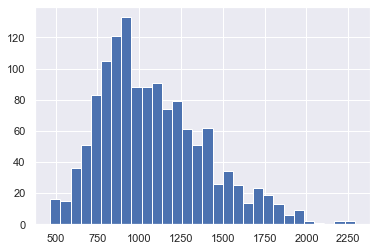

In [296]:
dt['The_Rest_Area'].hist(bins = 30)

`-` 지상층 생활 면적과 나머지들의 면적을 로그 변환하자(오른쪽으로 꼬리가 긴 분포)

In [297]:
dt['Gr_Liv_Area'] = np.log(dt['Gr_Liv_Area'])
dt['The_Rest_Area'] = np.log(dt['The_Rest_Area']) 

`-` Overall_Qual을 제외한 Quality 관련변수들은 서로 비슷비슷하다(화장실 개수와 차고에 들어가는 차량 개수 피쳐도 포함)

`-` 이들의 평균을 새로운 파생 변수로 만들어 사용하자

In [298]:
dt['The_Rest_Qual'] = (dt['Exter_Qual'] + dt['Kitchen_Qual'] + dt['Bsmt_Qual'] + dt['Full_Bath'] + dt['Garage_Cars']) / 5

`-` 쓰지 않는 피쳐들은 드랍하자

In [299]:
dt.drop(['Garage_Area', 'Garage_Cars', 'Exter_Qual', 'Kitchen_Qual', 'Bsmt_Qual', 'Full_Bath', 'Total_Bsmt_SF', 'first_Flr_SF'], axis = 1, inplace = True)

In [300]:
dt.head() ## 전처리가 잘 되었다

,Overall_Qual,Gr_Liv_Area,After_1980Year_Built,The_Rest_Area,The_Rest_Qual
0,10,7.779885,1,7.714231,3.4
1,7,7.209340,1,7.100027,2.8
2,5,6.802395,0,6.659294,1.6
3,5,7.068172,0,6.730222,2.0
4,7,7.579679,1,7.176255,2.8


## 모델링(랜덤 포레스트)

`-` 랜덤 포레스트를 사용해보자

### 스케일링

`-` z-점수 스케일링이나 로버스트 스케일링이나 비슷하다

`-` 로그변환을 통해 분포를 종모양 비슷하게 맞춰줬으니 z-점수 스케일링을 하겠다

`-` 계수를 통해 Overall_Qual과 Gr_Liv_Area이 매우 중요하며 그 다음은 Bsmt_Qual이다

`-` Kitchen_Qual과 Total_Bsmt_SF이 그 다음이며 나머지는 비슷하다

In [301]:
from sklearn.preprocessing import StandardScaler

In [302]:
## z-score 스케일러 생성
standard_scaler = StandardScaler()

## 스케일링
dt_scaled = standard_scaler.fit_transform(dt)
dt_scaled_df = pd.DataFrame(data = dt_scaled, columns = dt.columns)

In [303]:
dt_scaled_df.head()

,Overall_Qual,Gr_Liv_Area,After_1980Year_Built,The_Rest_Area,The_Rest_Qual
0,2.937740,1.672393,1.140631,2.659203,2.456424
1,0.618930,-0.200761,1.140631,0.543832,1.228366
2,-0.926943,-1.536803,-0.876708,-0.974091,-1.227750
3,-0.926943,-0.664230,-0.876708,-0.729808,-0.409045
4,0.618930,1.015096,1.140631,0.806365,1.228366


`-` 또한 Qual 관련 변수로 Overall Qual만 사용해봤는데 성능이 더 안좋게 나왔다(선형 회귀)

`-` 그래서 Qual 관련 변수를 추가했다

`-` 또한 현재 연도에서 완공 연도의 차이를 파생변수로 만들어 추가했다

`-` 사실 연도 변수는 포함시킬지 말지 고민했다

`-` 최근 연도일수록 집값이 평균적으로 높을텐데

`-` 이는 연도때문이라기 보다는 다른 변수에 의한 것이라 생각했기 때문이다

`-` 예컨대 과거에는 기술 등의 문제로 더 좋은 건물을 짓지 못했지만 최근에는 가능해진 상황

`-` 하지만 train 셋에 포함된 피쳐외의 특징을 연도 피쳐가 가지고 있을 수 있으니 포함하고 모델링 해보기로 했다

### 교차 검증

In [128]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split, cross_validate
from sklearn.metrics import make_scorer

In [304]:
x_train, x_valid, y_train, y_valid = train_test_split(dt_scaled_df, target, shuffle = True, test_size = 0.2, random_state = 22)

In [305]:
log_y_train = np.log(y_train)

`-` 데이터를 train과 valid로 나눈다

`-` 그리고 train에 대해 교차검증(train을 train2와 valid2로 나누어 모형을 평가)을 한다

`-` 그리고 교차검증에 사용한 모델로 valid를 평가한다

`-` 교차검증을 통해 측정한 성능과 valid로 측정한 성능이 둘 다 좋다면 괜찮은 모델이다

In [306]:
def NMAE(true, pred):
    mae = np.mean(np.abs(true - pred))
    score = mae / np.mean(np.abs(true))
    return score

In [307]:
def my_custom_loss_func(true, pred):
    return NMAE(np.exp(true), np.exp(pred)) ## 로그 변환을 위한 손실 함수

In [308]:
score = make_scorer(my_custom_loss_func, greater_is_better = False) ## 작을수록 좋다 

In [311]:
rf = RandomForestRegressor(random_state = 22)

scores = cross_validate(rf, x_train, log_y_train, scoring = score, return_train_score = True, cv = 5)

In [315]:
rf.fit(x_train, log_y_train)
print('교차 검증별 NMAE: ', -scores['test_score'])
print('평균 교차 검증 NMAE: ', np.mean(-scores['test_score']))
print('valid에 대한 검증 NMAE: ', NMAE(y_valid, np.exp(rf.predict(x_valid))))

교차 검증별 NMAE:  [0.10650992 0.10620135 0.08954716 0.10849187 0.08975168]
평균 교차 검증 NMAE:  0.10010039686130394
valid에 대한 검증 NMAE:  0.10203871350920847


In [316]:
list(zip(rf.feature_names_in_,rf.feature_importances_))

[('Overall_Qual', 0.15285131970403082),
 ('Gr_Liv_Area', 0.1645673496034866),
 ('After_1980Year_Built', 0.0035522971811383767),
 ('The_Rest_Area', 0.11690237297839685),
 ('The_Rest_Qual', 0.5621266605329474)]

`-` Overall_Qual을 제외한 피쳐들을 평균낸 피쳐인 The_Rest_Qual의 중요도가 0.56이다

In [42]:
list(zip(rf.feature_names_in_,rf.feature_importances_))

[('Overall_Qual', 0.5431834936782366),
 ('Gr_Liv_Area', 0.14604383594613135),
 ('Exter_Qual', 0.04233756499335442),
 ('Garage_Cars', 0.007818304293604469),
 ('Garage_Area', 0.07120858446964971),
 ('Kitchen_Qual', 0.009051944221832066),
 ('Total_Bsmt_SF', 0.04673881137609024),
 ('first_Flr_SF', 0.04624833278829917),
 ('Bsmt_Qual', 0.014066815219848707),
 ('Full_Bath', 0.01997589290936081),
 ('gap_year_now_bulit', 0.053326420103592405)]

`-` 전체적인 품질과 지상층 면적이 중요도의 약 70%를 차지함(예전 방식)

### 하이퍼 파라미터 튜닝

`-` 디폴트 옵션에 대한 성능은 위에서 확인했다

`-` 하이퍼 파라미터 튜닝을 통해 성능을 더 올려보자

In [43]:
params = {'n_estimators': [100, 200], 'max_depth': [6, 10, 15], 'min_samples_split': [4, 5, 6]}

In [44]:
rf = RandomForestRegressor(random_state = 22)

In [45]:
grid_rf = GridSearchCV(rf, param_grid = params, scoring = score, cv = 5, refit = True)

In [46]:
grid_rf.fit(x_train, log_y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=22),
             param_grid={'max_depth': [6, 10, 15],
                         'min_samples_split': [4, 5, 6],
                         'n_estimators': [100, 200]},
             scoring=make_scorer(my_custom_loss_func, greater_is_better=False))

In [50]:
-grid_rf.best_score_

0.09295432419744803

In [48]:
grid_rf.best_estimator_

RandomForestRegressor(max_depth=10, min_samples_split=6, n_estimators=200,
                      random_state=22)

`-` 조금 성능이 올랐다(예전 이상치 제거 방식과 피쳐 샐렉션 방식을 사용했을 때 기준; 현재는 모름)

### test 예측

`-` 아래는 예전 방식의 내용임

`-` 현재 방식을 사용하지 않은 이유는 교차 검증 결과가 좋지 않아서...

`-` 랜덤 포레스트 10겹 교차검증을 통해 test를 예측하자

`-` 즉 동일한 랜덤 포레스트 모델(훈련 데이터가 다름) 10개를 만들고 이들의 평균을 구하는 것

In [208]:
from sklearn.model_selection import KFold

In [55]:
test['gap_year_now_bulit'] = 2022 - test['Year_Built']

`-` train 셋에 포함된 피쳐외의 특징을 연도 피쳐가 가지고 있을 수 있으니 연도 변수로 위의 파생 변수를 사용하자

In [56]:
test.drop(['Year_Built', 'Year_Remod_Add', 'Garage_Yr_Blt'], axis = 1, inplace = True)

`-` 차고 면적은 차고 자리 개수와 관련이 있다

`-` 차고 자리 개수에 따라 차고 면적의 분포가 다름

`-` 그렇기에 원핫인코딩을 하고 둘을 곱한 파생 변수를 만들고 로그 변환을 해주자(오른쪽으로 꼬리가 긴 분포)

`-` 그런데 일단은 하지 말자(하지 말고 그냥 드랍하자)

`-` 지상층 생활 면적과 1층 면적과 지하실 면적과 연도를 로그 변환하자(오른쪽으로 꼬리가 긴 분포)

In [57]:
test['Gr_Liv_Area'] = np.log(test['Gr_Liv_Area'])
test['first_Flr_SF'] = np.log(test['first_Flr_SF'])
test['Total_Bsmt_SF'] = np.log(test['Total_Bsmt_SF'])
test['gap_year_now_bulit'] = np.log(test['gap_year_now_bulit']) ## 솔직히 유용한지 잘 모르겠지만 score가 더 잘나와서 씀

In [209]:
for col in test.columns[test.dtypes == 'object']:
    test[col] = test[col].apply(lambda x: label_encoding(x))

In [59]:
test_scaled = robust_scaler.transform(test)
test_scaled_df = pd.DataFrame(data = test_scaled, columns = test.columns)

In [60]:
test_scaled_df.head() ## 로그 변환이 잘 되었다

,Overall_Qual,Gr_Liv_Area,Exter_Qual,Garage_Cars,Garage_Area,Kitchen_Qual,Total_Bsmt_SF,first_Flr_SF,Bsmt_Qual,Full_Bath,gap_year_now_bulit
0,1.5,0.526539,1.0,0.0,1.095477,2.0,1.261657,1.137370,1.0,0.0,-0.938580
1,0.0,-0.676332,0.0,-1.0,-1.226131,0.0,0.143670,-0.021998,-1.0,-1.0,0.398203
2,0.0,0.207959,1.0,0.0,-0.221106,1.0,-0.643845,-0.799827,0.0,0.0,-0.617795
3,0.0,1.248390,1.0,1.0,1.306533,1.0,0.292779,0.132630,0.0,0.0,-0.785871
4,-0.5,-0.769897,0.0,0.0,1.015075,0.0,0.056708,-0.112179,-1.0,-1.0,0.134299


In [220]:
kfold = KFold(n_splits = 10, random_state = 22, shuffle = True)

In [223]:
log_target = np.log(target)

In [66]:
rf_predict = np.zeros(test.shape[0])

for train_idx, valid_idx in kfold.split(dt_scaled_df, log_target):
    x_train, y_train = dt_scaled_df.iloc[train_idx], log_target.iloc[train_idx]
    x_valid, y_valid = dt_scaled_df.iloc[valid_idx], np.exp(log_target.iloc[valid_idx])
    
    rf = RandomForestRegressor(random_state = 22, criterion = 'absolute_error', n_estimators = 200, max_depth = 10, min_samples_leaf = 6) ## 훈련
    rf.fit(x_train, y_train)
    
    test_predict = np.exp(rf.predict(test_scaled_df)) ## test셋 예측
    rf_predict += test_predict / 10 ## test 예측값(10 Fold)

In [67]:
submission = pd.read_csv('C:/Users/Jaesu/github_desktop/Dacon-Basic/집값-예측/Data/sample_submission.csv')

In [68]:
## 위에서 구한 예측값을 그대로 넣어줌
submission['target'] = rf_predict

## 데이터가 잘 들어갔는지 확인
submission.head()

,id,target
0,1,326439.419625
1,2,135078.056709
2,3,178239.410762
3,4,223829.937251
4,5,133786.154097


In [69]:
## submission을 csv 파일로 저장
submission.to_csv('C:/Users/Jaesu/github_desktop/Dacon-Basic/집값-예측/Data/submission5.csv', index = False)

`-` 점수는 약 $0.11057$이다